# Intro to Regularization



In [1]:
# Python 2 & 3 Compatibility
from __future__ import print_function, division

# Necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold

%matplotlib inline

### Regularized Regression with sklearn
As we've discussed, **regularization** is basically a blanket term for any technique that alters a model to prevent **overfitting**.  In linear regression, this is generally done by adding a term to the **Cost function** that is increasing in the absolute value of the coefficients.  The upshot of this is that models with large coefficients are implicitly punished by increasing their cost function, and the underlying mathematics of regression seek to choose the model that minimizes the value of the cost function.

There are 2 very common regularization techniques for regression, called **"Ridge Regression"** and **"Lasso Regression"**

##### Ridge Regression
[Ridge Regression](http://scikit-learn.org/stable/modules/linear_model.html#ridge-regression) adds the L2 norm (square root of the sum of squares) of the coefficients to the cost function.

##### Lasso Regression
[Lasso Regression](http://scikit-learn.org/stable/modules/linear_model.html#lasso) adds the L1 norm (sum of absolute values) of the coefficients to the cost function.

##### ElasticNet Regression
[ElasticNet Regression](http://scikit-learn.org/stable/modules/linear_model.html#elastic-net) simply combines both by adding **both** the **L1** and **L2** norm seeking the best of both worlds.

sklearn has specific model types for both of the above regressions which we will see some of below.  Essentially, there is a "punishment parameter" alpha that these models try several different values of with cross-validation and then they return the value and model that yields the best generalization.  The beauty of this is that it all (optionally) happens completely under the covers!  We will use **RidgeCV** later in the exercises to perform regression with automatic Regularization and Cross-Validation.

## Polynomial Regression Revisited
To see how to use Regularized Regression we're going to revisit our generated data which we were using to fit polynomial regressions.

#### Reload the Data
Let's reload the `X` and `y` numpy arrays as follows:

In [2]:
# Load the file
npz = np.load('../../week02-luther1/05-probability/data/poly_data.npz')
# Retrieve each array
X = npz['arr_0']
y = npz['arr_1']


### Visualizing Overfitting: The need for Regularization
Now that we have our data again we're going to train some increasingly complex (increasing degree) polynomials and watch what happens to the training and test errors as complexity increases.  Let's take a look at the data as we did before except this time we'll split into a train and test set first via `train_test_split`.

Don't worry about the `sklearn` details of this right now, the **focus is on regularization**.  Essentially, we're training our model against one set and then testing it against some previously unknown set.

Now we're ready to see what happens as we increase the degree of our polynomials and fit each one.  The below code will generate a plot of the error as a function of polynomial degree for degree 1-9:

In [3]:
 X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8)

/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


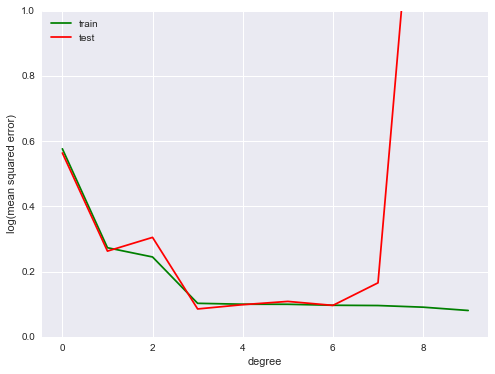

In [4]:
from sklearn.metrics import mean_squared_error

# Step through degrees from 0 to 9 and store the training and test (generalization) error.
train_error = np.empty(10)
test_error = np.empty(10)
for degree in range(10):
    est = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    est.fit(X_train, y_train)
    train_error[degree] = mean_squared_error(y_train, est.predict(X_train))
    test_error[degree] = mean_squared_error(y_test, est.predict(X_test))

# Plot the training and test errors against degree
plt.figure(figsize=(8,6))
plt.plot(np.arange(10), train_error, color='green', label='train')
plt.plot(np.arange(10), test_error, color='red', label='test');
plt.ylim((0.0, 1e0))
plt.ylabel('log(mean squared error)')
plt.xlabel('degree')
plt.legend(loc='upper left')


**What do you notice?**

The higher the degree of the polynomial (our proxy for model complexity), the lower the training error. The testing error decreases too, but it eventually reaches its minimum at a degree of three and then starts increasing at a degree of seven. 

This is a visual demonstration of ***overfitting***: the model is already so complex that it fits the idiosyncrasies of our training data, idiosyncrasies which limit the model's ability to generalize (as measured by the testing error).

In the above example, the optimal choice for the degree of the polynomial approximation would be between three and six. So when we get some data, we could fit a bunch of polynomials and then choose the one that minimizes MSE.

### Visualizing Regularized Regression

#### Hand picking polynomials is hard work, and data scientists are lazy so....
...we would like a method that eliminates the need to manually select the degree of the polynomial: we can add a constraint to our linear regression model that constrains the magnitude of the coefficients in the regression model. This constraint is called the regularization term and the technique is often called shrinkage in the statistical community because it shrinks the coefficients towards zero. In the context of polynomial regression, constraining the magnitude of the regression coefficients effectively is a smoothness assumption: by constraining the L2 norm of the regression coefficients we express our preference for smooth functions rather than wiggly functions.

A popular regularized linear regression model is Ridge Regression. This adds the L2 norm of the coefficients to the ordinary least squares objective:

  $J(\boldsymbol\beta) = \frac{1}{n}\sum_{i=0}^n (y_i - \boldsymbol\beta^T \mathbf{x}_i')^2 + \alpha \|\boldsymbol\beta\|_2$

where $\boldsymbol\beta$ is the vector of coefficients including the intercept term and $\mathbf{x}_i'$ is the i-th feature fector including a dummy feature for the intercept. The L2 norm term is weighted by a regularization parameter ``alpha``: if ``alpha=0`` then you recover the Ordinary Least Squares regression model. The larger the value of ``alpha`` the higher the smoothness constraint.

Below you can see the approximation of a [``sklearn.linear_model.Ridge``](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) estimator fitting a polynomial of degree nine for various values of ``alpha`` (left) and the corresponding coefficient loadings (right). The smaller the value of ``alpha`` the higher the magnitude of the coefficients, so the functions we can model can be more and more wiggly. 

In [5]:
# Bringing in our helper functions

def f(x):
    return np.sin(2 * np.pi * x)

def plot_approximation(est, ax, label=None):
    """Plot the approximation of ``est`` on axis ``ax``. """
    ax.plot(x_plot, f(x_plot), label='ground truth', color='green')
    ax.scatter(X, y, s=100)
    ax.plot(x_plot, est.predict(x_plot[:, np.newaxis]), color='red', label=label)
    ax.set_ylim((-2, 2))
    ax.set_xlim((0, 1))
    ax.set_ylabel('y')
    ax.set_xlabel('x')
    ax.legend(loc='upper right',frameon=True)

x_plot = np.linspace(0, 1, 100)

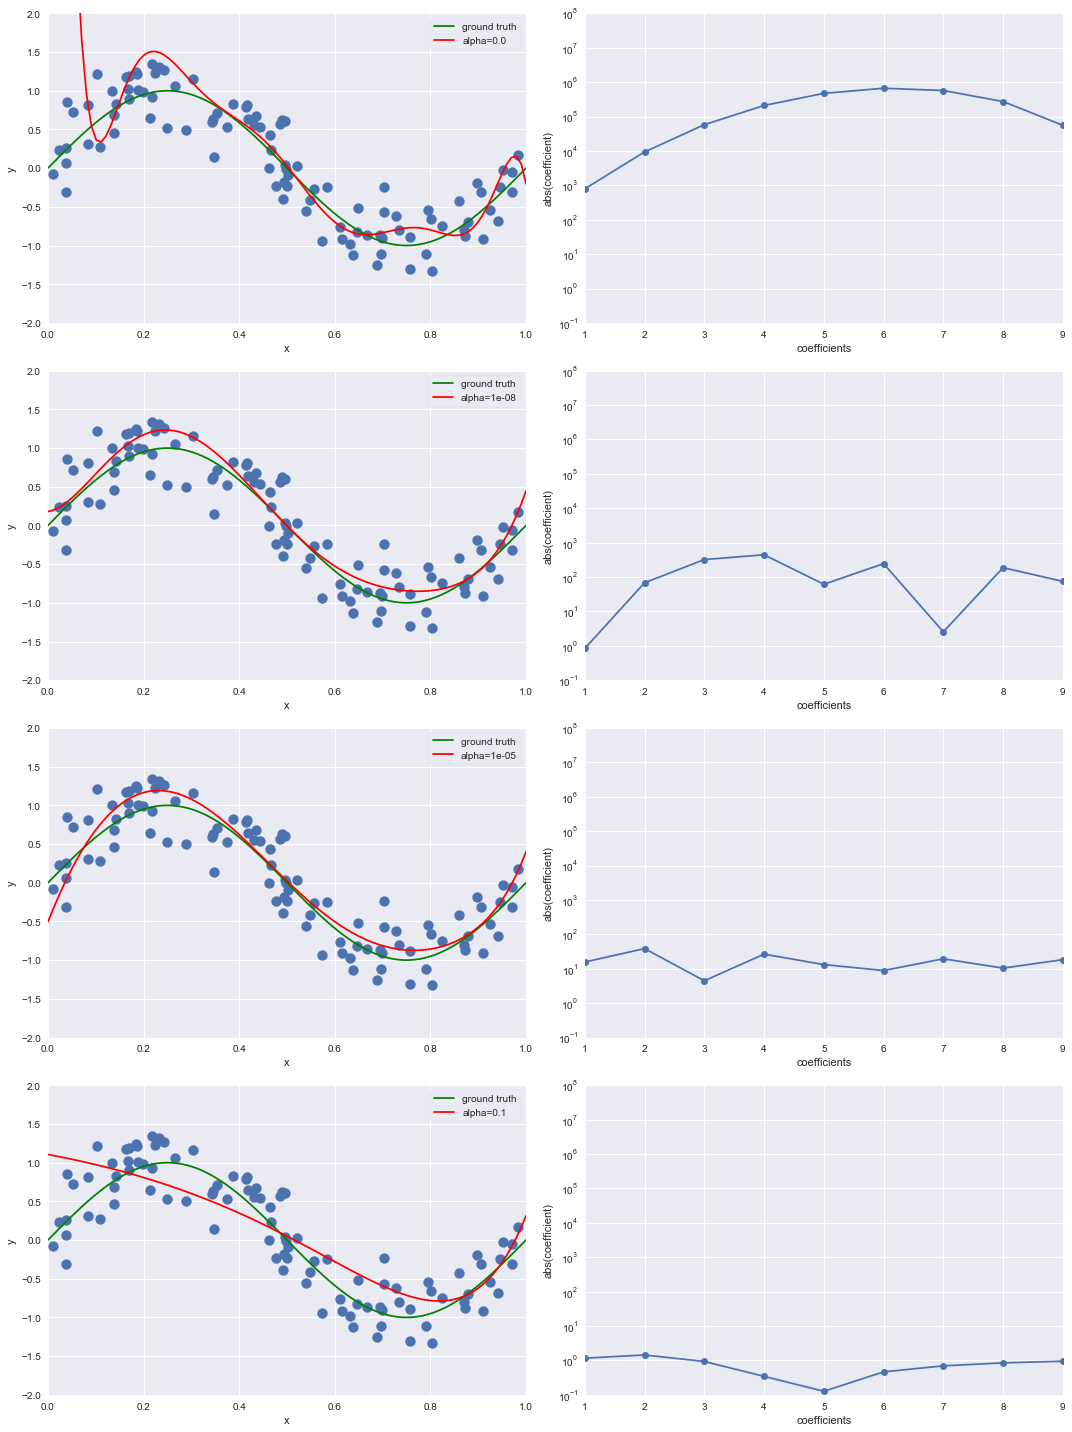

In [6]:
from sklearn.linear_model import Ridge

# Set up a figure and axes for 8 plots, 2 per row for 4 rows
fig, ax_rows = plt.subplots(4, 2, figsize=(15, 20))

# A helper function to plot the absolute value of the coefficients on the right-hand column plot
def plot_coefficients(est, ax, label=None, yscale='log'):
    # getting our coefficients from the estimator
    coef = est.steps[-1][1].coef_.ravel()
    if yscale == 'log':
        ax.semilogy(np.abs(coef), marker='o', label=label)
        ax.set_ylim((1e-1, 1e8))
    else:
        ax.plot(np.abs(coef), marker='o', label=label)
    ax.set_ylabel('abs(coefficient)')
    ax.set_xlabel('coefficients')
    ax.set_xlim((1, 9))

# Try out 4 different values of the RidgeRegression parameter alpha and watch how the resulting models change
# With higher values of alpha, more complex (more wiggly) models will be more punished and thus less likely
degree = 9
alphas = [0.0, 1e-8, 1e-5, 1e-1]
for alpha, ax_row in zip(alphas, ax_rows):
    ax_left, ax_right = ax_row
    est = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=alpha))
    est.fit(X_train, y_train)
    plot_approximation(est, ax_left, label='alpha=%r' % alpha)
    plot_coefficients(est, ax_right, label='Ridge(alpha=%r) coefficients' % alpha)

plt.tight_layout()

##### Now with the LASSO...

In the above example we used Ridge Regression, a regularized linear regression technique that puts an [L2 norm](http://mathworld.wolfram.com/L2-Norm.html) penalty on the regression coefficients. As mentioned above, another popular regularization technique is the LASSO, a technique which puts an [L1 norm](http://mathworld.wolfram.com/L1-Norm.html) penalty instead. The difference between the two is that the LASSO leads to sparse solutions, driving most coefficients to zero, whereas Ridge Regression leads to dense solutions, in which most coefficients are non-zero.

Let's check out the same process using the LASSO:

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


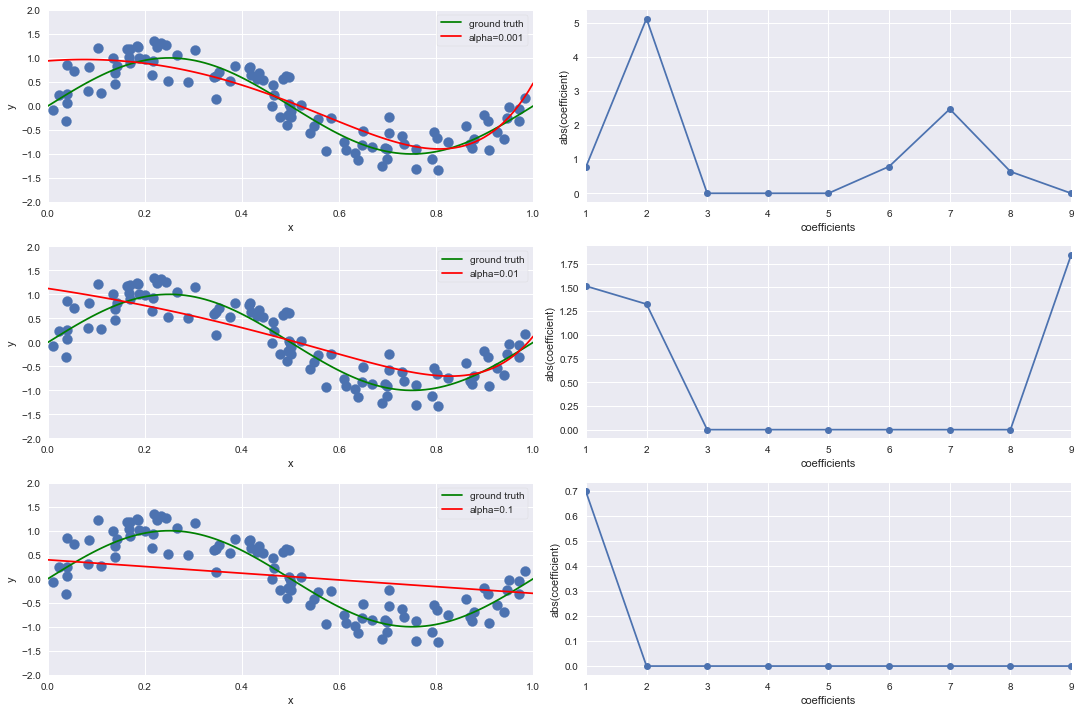

In [7]:
from sklearn.linear_model import Lasso

# Create only 2 plot rows, only trying 2 alphas
fig, ax_rows = plt.subplots(3, 2, figsize=(15, 10))

# Plot the results next to the coefficient values for each of the 2 alphas
degree = 9
alphas = [1e-3, 1e-2,1e-1]
for alpha, ax_row in zip(alphas, ax_rows):
    ax_left, ax_right = ax_row
    est = make_pipeline(PolynomialFeatures(degree), Lasso(alpha=alpha))
    est.fit(X_train, y_train)
    plot_approximation(est, ax_left, label='alpha=%r' % alpha)
    plot_coefficients(est, ax_right, label='Lasso(alpha=%r) coefficients' % alpha, yscale=None)

plt.tight_layout()

Notice that for the Lasso many of the coefficients are zero.  When you choose an sklearn model that encapsulates both Regularization and Cross-Validation (like [**RidgeCV**](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html) to be used below for instance) sklearn will choose the best value from several options of ***alpha*** by cross-validating in whatever way you decide.

##### And with ElasticNet...
Remember this tries to find the best of both worlds, with both L1 and L2 regularization:

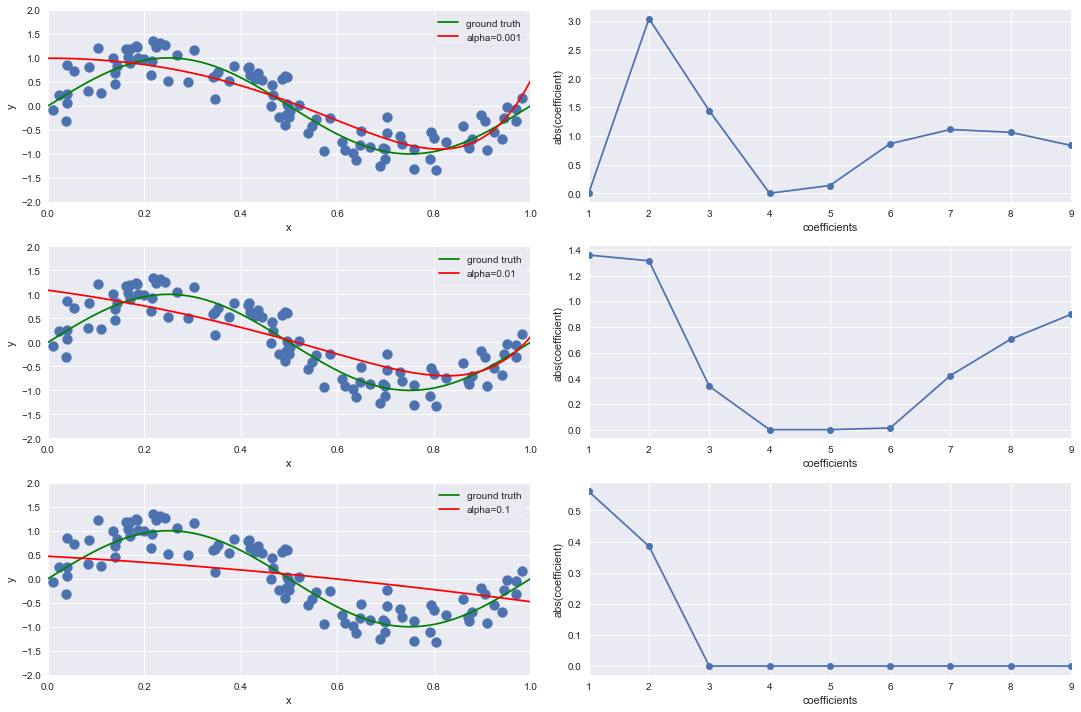

In [8]:
from sklearn.linear_model import ElasticNet

# Create only 2 plot rows, only trying 2 alphas
fig, ax_rows = plt.subplots(3, 2, figsize=(15, 10))

# Plot the results next to the coefficient values for each of hte 2 alphas
degree = 9
alphas = [1e-3, 1e-2,1e-1]
for alpha, ax_row in zip(alphas, ax_rows):
    ax_left, ax_right = ax_row
    est = make_pipeline(PolynomialFeatures(degree), ElasticNet(alpha=alpha))
    est.fit(X_train, y_train)
    plot_approximation(est, ax_left, label='alpha=%r' % alpha)
    plot_coefficients(est, ax_right, label='ElasticNet(alpha=%r) coefficients' % alpha, yscale=None)

plt.tight_layout()

Notice that this is some sort of hybrid of the look/feel of the Lasso and Ridge!  

Congratulations, you understand regularization!

**Remember:** regularization is a general concept.  It's any adjustment to the actual modeling step that tries to inherently control for overfitting, most often by augmenting the cost function.

In [9]:

# Let's get back to the cars ~ Import the car dataframe via the picklefile again

cars=pd.read_pickle('../../week02-luther1/05-probability/data/cars2frame.pkl')

cars.head(1)

y=cars['log_price']
X=cars.drop(['log_price','price'],1)

In [10]:
# As we saw before, here is our baseline r^2 score
lr=LinearRegression()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.8674385425066202


### Automatic Cross-Validation with sklearn
So far we've just been using train/test splits for cross-validation and we haven't let sklearn do the work for us.  We also haven't even touched regularization.  So here we're going to do both, and we're going to do it in just 3 lines!

First, import sklearn.linear_model.RidgeCV

In [11]:
from sklearn.linear_model import RidgeCV

Now, create a `RidgeCV` object with the parameter `cv` set to 10.  

What this will do is perform [10-fold cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)#k-fold_cross-validation).  The CV in RidgeCV means that is has this capability built in.  Because this is a Ridge Regressor, it also has regularization built in.  You can check out the [RidgeCV Documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html) to see the default values it uses for `alpha` (they are configurable as a parameter of course).

In [12]:
rcv = RidgeCV(cv=10)  #shift-tab here 

In [13]:
# Ridge & CrossVal in one: 

rcv.fit(X, y)
rcv.score(X_test, y_test)

0.8846571449664241

Nice!  We've already improved our baseline model and with cross-validation and regularization we have an estimate of our model's future performance that we should feel reasonably comfortable reporting to our boss.


In [14]:
## STUDENT SECTION: 

# Using Ridge, Lasso and/or ElasticNet together with cross-validation, 
# Tune your alpha parameter to determine which alpha minimizes Mean-squared Error
# Plot your results 

## Hint (before you go too far): see the note here about L1 & L2 
# http://scikit-learn.org/stable/modules/preprocessing.html
